In [15]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.tools import tool
from langchain_core.messages import HumanMessage, BaseMessage

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from typing import Annotated, TypedDict

from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model='gpt-4o-mini')

In [4]:
loader = PyPDFLoader("intro-to-ml.pdf")
docs = loader.load()

In [5]:
len(docs)

392

In [6]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(documents=docs)

In [7]:
len(chunks)

973

In [8]:
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
vector_store = FAISS.from_documents(chunks, embeddings)

In [9]:
vector_store

In [10]:
retriever = vector_store.as_retriever(search_type='similarity', search_kargs={'k':4})

In [ ]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [12]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools=tools)

In [13]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [14]:
def chat_node(state: ChatState):
    
    messages = state["messages"]
    
    response = llm_with_tools.invoke(messages)
    
    return{'messages': [response]}

In [16]:
tool_node = ToolNode(tools=tools)

In [17]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

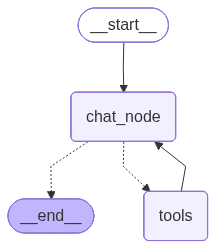

In [18]:
chatbot

In [19]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the PDF notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

In [20]:
print(result['messages'][-1].content)

To find the ideal value of \( K \) in the k-nearest neighbors (k-NN) algorithm, follow these key considerations:

1. **Definition of \( K \)**: In k-NN, \( K \) represents the number of nearest neighbors used to make predictions. Instead of only considering the closest neighbor, you can choose a fixed number of neighbors (like the closest three or five), and make a prediction based on the majority class among these neighbors.

2. **Range of \( K \)**:
   - **Small Values**: A small value of \( K \) (like 1) can lead to a model that is highly sensitive to noise in the data, as predictions will rely heavily on the nearest single point.
   - **Larger Values**: A larger \( K \) can smooth out the decision boundary but may also overlook the finer patterns in the data, potentially leading to underfitting.

3. **Choosing the Value of \( K \)**:
   - **Cross-Validation**: One effective method to determine the ideal \( K \) is to use cross-validation. You can test multiple values of \( K \) (e.